# Preprocessing

## Import

In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, f1_score, make_scorer, roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import re
from bs4 import BeautifulSoup
from textblob import TextBlob
from tqdm import tqdm
from nltk import word_tokenize, pos_tag, pos_tag_sents

nltk.download('stopwords')
stop = stopwords.words('english')

nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/venesia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/venesia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/venesia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocess text

In [4]:
df = pd.read_csv('./dataset/train.csv')
df2 = pd.read_csv('./dataset/test.csv')
df2.head()

Id                                       Page content
0  27643  <html><head><div class="article-info"><span cl...
1  27644  <html><head><div class="article-info"><span cl...
2  27645  <html><head><div class="article-info"><span cl...
3  27646  <html><head><div class="article-info"><span cl...
4  27647  <html><head><div class="article-info"><span cl...

In [3]:
import re
from bs4 import BeautifulSoup

def preprocessor(text, lem=True):
    text = re.sub(r'u.s.', 'United States', str(text).lower().strip())
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    lst_text = text.split()
    if stop is not None:
        lst_text = [word for word in lst_text if word not in stop]
    
    if lem:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)
    return text

## Extract Title

1. Title clean after preprocess and title length

In [7]:
def preprocess_title(text):
    soup = BeautifulSoup(text, 'html.parser')
    title = soup.find("h1", {"class":"title"}).get_text()
    title = preprocessor(title)
    return title
df['Title'] = df['Page content'].apply(lambda x: preprocess_title(x))
df['Title length'] = df['Title'].apply(lambda x: len(x.split()))

df2['Title'] = df2['Page content'].apply(lambda x: preprocess_title(x))
df2['Title length'] = df2['Title'].apply(lambda x: len(x.split()))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  
0  soccer star get twitter death threat tackling ...            10  
1                   google glass get accessory store             5  
2            ouya gaming console already sold amazon             6  
3                        two fern mock oscar nominee             5  
4  american sniper trailer look like eastwood may...             9

In [26]:
df2.isnull().sum()

Id               0
Page content     0
Title            0
Title length     0
Title clean      0
Images           0
Links            0
Content          0
Clean            0
Word count       0
Day              1
Month            1
Hour             1
Topics           0
Topics length    0
dtype: int64

2. Title without preprocess

In [10]:
def preprocess_title(text):
    soup = BeautifulSoup(text, 'html.parser')
    title = soup.find("h1", {"class":"title"}).get_text()
    # title = preprocessor(title)
    return title
df['Title clean'] = df['Page content'].apply(lambda x: preprocess_title(x))
df2['Title clean'] = df2['Page content'].apply(lambda x: preprocess_title(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  
0  Soccer Star Gets Twitter Death Threats After T...  
1               Google Glass Gets an Accessory Store  
2     OUYA Gaming Console Already Sold Out on Amazon  
3           'Between Two Ferns' Mocks Oscar Nominees  
4  'American Sniper' Trailer: Looks Like Eastwood...

## Extract number of images

In [13]:
def extract_num_of_images(text):
    soup = BeautifulSoup(text, 'html.parser')
    images = soup.find_all("img")
    return len(images)
df["Images"] = df["Page content"].apply(lambda x: extract_num_of_images(x))
df2["Images"] = df2["Page content"].apply(lambda x: extract_num_of_images(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  
0  Soccer Star Gets Twitter Death Threats After T...       1  
1               Google Glass Gets an Accessory Store       3  
2     OUYA Gaming Console Already Sold Out on Amazon       2  
3           'Between Two Ferns' Mocks Oscar Nominees       1  
4  'American Sniper' Trailer: Looks Like Eastwood...       1

## Extract number of links

In [15]:
def extract_num_of_links(text):
    soup = BeautifulSoup(text, 'html.parser')
    links = soup.find_all("a")
    return len(links)
df["Links"] = df["Page content"].apply(lambda x: extract_num_of_links(x))
df2["Links"] = df2["Page content"].apply(lambda x: extract_num_of_links(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  
0  Soccer Star Gets Twitter Death Threats After T...       1     30  
1               Google Glass Gets an Accessory Store       3     13  
2     OUYA Gaming Console Already Sold Out on Amazon       2     13  
3           'Between Two Ferns' Mocks Oscar Nominees       1     15  
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10

## Preprocess page content and extract the page content without preprocess

In [16]:
def clean(text, pre=True):
    soup = BeautifulSoup(text, 'html.parser')
    txt = soup.find("section", {"class":"article-content"}).get_text()
    if pre:
        txt = preprocessor(txt)
    return txt

df["Content"] = df["Page content"].apply(lambda x: clean(x, pre=True))
df["Clean"] = df["Page content"].apply(lambda x: clean(x, pre=False))

df2["Content"] = df2["Page content"].apply(lambda x: clean(x, pre=True))
df2["Clean"] = df2["Page content"].apply(lambda x: clean(x, pre=False))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  
0       Note to humanity: One Direction fandom ai...  
1   Shortly after announcing a hardware upgrade f...  
2   Well, that was quick. Just hours after going ...  
3    Between Two Ferns: Oscar Buzz Edition Part 1...  
4       Ever since The Hurt Locker it seems like ...

In [17]:
def word_count(content):
    return len(content.split())
df["Word count"] = df["Content"].apply(lambda x: word_count(x))
df2["Word count"] = df2["Content"].apply(lambda x: word_count(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  
0       Note to humanity: One Direction fandom ai...         355  
1   Shortly after announcing a hardware upgrade f...          83  
2   Well, that was quick. Just hours after going ...         111  
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  
4       Ever since The Hurt Locker it seems like ...         139

In [21]:
df2.isnull().sum()

Id              0
Page content    0
Title           0
Title length    0
Title clean     0
Images          0
Links           0
Content         0
Clean           0
Word count      0
Day             1
dtype: int64

## Extract day

In [20]:
import datetime

def extract_day(text):
    soup = BeautifulSoup(text, 'html.parser')
    time = soup.find('time').get('datetime')
    if time is None:
        return np.nan
    return time[:3]

df["Day"] = df["Page content"].apply(lambda x: extract_day(x))
df2["Day"] = df2["Page content"].apply(lambda x: extract_day(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  Day  
0       Note to humanity: One Direction fandom ai...         355  Mon  
1   Shortly after announcing a hardware upgrade f...          83  Thu  
2   Well, that was quick. Just hours after going ...         111  Tue  
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  Wed  
4       Ever since The Hurt Locker it seems like ...         139  Fri

## Extract month

In [22]:
def extract_month(text):
    soup = BeautifulSoup(text, 'html.parser')
    
    date = soup.find("time").get_text()
    if date == '':
        return np.nan
    date = date.split()[0]
    year, month, day = date.split("-")
    
    return int(month)

df["Month"] = df["Page content"].apply(lambda x: extract_month(x))
df2["Month"] = df2["Page content"].apply(lambda x: extract_month(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  Day  Month  
0       Note to humanity: One Direction fandom ai...         355  Mon    9.0  
1   Shortly after announcing a hardware upgrade f...          83  Thu   10.0  
2   Well, that was quick. Just hours after going ...         111  Tue    6.0  
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  Wed    2.0  
4       Ever since The Hurt Locker it seems like ...         139  Fri   10.0

## Extract hour

In [25]:
def extract_hour(text):
    soup = BeautifulSoup(text, 'html.parser')
    time = soup.find('time').get_text()
    if time == '':
        return np.nan
    time = time.split()[1]
    hour = time.split(":")[0]
    return int(hour)

df["Hour"] = df["Page content"].apply(lambda x: extract_hour(x))
df2["Hour"] = df2["Page content"].apply(lambda x: extract_hour(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  Day  Month  \
0       Note to humanity: One Direction fandom ai...         355  Mon    9.0   
1   Shortly after announcing a hardware upgrade f...          83  Thu   10.0   
2   Well, that was quick. Just hours after going ...         111  Tue    6.0   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  Wed    2.0   
4       Ever since The Hurt Locker it seems like ...         139  Fri   10.0   

   Hour                                             Topics  Topics length  
0  19.0     sport one_direction music entertainment soccer              5  
1   9.0              gadget tech google_glass google glass              5  
2  12.0               business gaming amazon amazon_kindle              4  
3   3.0  video movie watercooler oscar_2013 oscar two_fern              6  
4   1.0  trailer movie bradley_cooper american_sniper a...              7

## Extract topics and topics length

In [27]:
def extract_topics(text):
    soup = BeautifulSoup(text, 'html.parser')

    a = soup.find("footer", {"class":"article-topics"})
    topics = []
    for i in a.find_all("a"):
        pre = preprocessor(i.get_text())
        topics.append("_".join(pre.split()))
    topics = " ".join(set(topics))
    return topics

df["Topics"] = df["Page content"].apply(lambda x: extract_topics(x))
df["Topics length"] = df["Topics"].apply(lambda x: len(x.split(' ')))

df2["Topics"] = df2["Page content"].apply(lambda x: extract_topics(x))
df2["Topics length"] = df2["Topics"].apply(lambda x: len(x.split(' ')))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  Day  Month  \
0       Note to humanity: One Direction fandom ai...         355  Mon    9.0   
1   Shortly after announcing a hardware upgrade f...          83  Thu   10.0   
2   Well, that was quick. Just hours after going ...         111  Tue    6.0   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  Wed    2.0   
4       Ever since The Hurt Locker it seems like ...         139  Fri   10.0   

   Hour                                             Topics  Topics length  
0  19.0     sport one_direction music entertainment soccer              5  
1   9.0              gadget tech google_glass google glass              5  
2  12.0               business gaming amazon amazon_kindle              4  
3   3.0  video movie watercooler oscar_2013 oscar two_fern              6  
4   1.0  trailer movie bradley_cooper american_sniper a...              7

## Extract Author

In [28]:
def extract_author(text):
    soup = BeautifulSoup(text, 'html.parser')
    txt = soup.find("span", {"class":"byline"})
    if txt == None:
        aut = soup.find('a', {'href': re.compile('publishers/')})
        if aut is None:
            return np.nan
        return aut.get_text()
    aut = soup.find("span",{"class": "author_name"})
    if aut:
        a = aut.get_text()
        a = a.split(" ")
        a = " ".join(a[1:])
    else:
        a = txt.get_text()
    return a


df["Author"] = df["Page content"].apply(lambda x: extract_author(x))
df2["Author"] = df2["Page content"].apply(lambda x: extract_author(x))
df2.head()

Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...

## Extract Date

In [31]:
def extract_date(text):
    soup = BeautifulSoup(text, 'html.parser')
    time = soup.find("time").get_text().split()
    if time == []:
        return np.nan
    date = time[0]
    year, month, day = date.split("-")
    
    return int(day)

# df["Date"] = df["Page content"].apply(lambda x: extract_date(x))
df2["Date"] = df2["Page content"].apply(lambda x: extract_date(x))
df.head()

Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...

## Sentiment Analysis

1. Content

for training set

In [33]:
sid = SentimentIntensityAnalyzer()

def sentimentContent(txt):
#     soup = BeautifulSoup(text, 'html.parser')
#     txt = soup.find("section", {"class":"article-content"}).get_text()
    
    dict_sentiment = {
        'neg': [],
        'neu': [],
        'pos': [],
        'compound': []
    }
    neg, neu, pos, compound = [], [], [], []
    for sentence in txt.split("."):
        sentiment = sid.polarity_scores(sentence)
        neg.append(sentiment['neg']) 
        neu.append(sentiment['neu'])
        pos.append(sentiment['pos'])
        compound.append(sentiment['compound'])
    
    dict_sentiment['neg'] = np.mean(neg)
    dict_sentiment['neu'] = np.mean(neu)
    dict_sentiment['pos'] = np.mean(pos)
    dict_sentiment['compound'] = np.mean(compound)
    return dict_sentiment

sentiment_test = df['Title'].apply(lambda x: sentimentContent(x))
dict_sentiment_test = {
    'neg': [],
    'neu': [],
    'pos': [],
    'compound': []
}
for s in sentiment_test:
    dict_sentiment_test['neg'].append(s['neg'])
    dict_sentiment_test['neu'].append(s['neu'])
    dict_sentiment_test['pos'].append(s['pos'])
    dict_sentiment_test['compound'].append(s['compound'])
    
df = pd.concat((df, pd.DataFrame.from_dict(dict_sentiment_test)), axis=1)
df.head()

for testing st

In [34]:
sentiment_test = df2['Title'].apply(lambda x: sentimentContent(x))
dict_sentiment_test = {
    'neg': [],
    'neu': [],
    'pos': [],
    'compound': []
}
for s in sentiment_test:
    dict_sentiment_test['neg'].append(s['neg'])
    dict_sentiment_test['neu'].append(s['neu'])
    dict_sentiment_test['pos'].append(s['pos'])
    dict_sentiment_test['compound'].append(s['compound'])
    
df2 = pd.concat((df2, pd.DataFrame.from_dict(dict_sentiment_test)), axis=1)
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  ... Month  \
0       Note to humanity: One Direction fandom ai...         355  ...   9.0   
1   Shortly after announcing a hardware upgrade f...          83  ...  10.0   
2   Well, that was quick. Just hours after going ...         111  ...   6.0   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  ...   2.0   
4       Ever since The Hurt Locker it seems like ...         139  ...  10.0   

   Hour                                             Topics Topics length  \
0  19.0     sport one_direction music entertainment soccer             5   
1   9.0              gadget tech google_glass google glass             5   
2  12.0               business gaming amazon amazon_kindle             4   
3   3.0  video movie watercooler oscar_2013 oscar two_fern             6   
4   1.0  trailer movie bradley_cooper american_sniper a...             7   

           Author  Date    neg    neu    pos  compound  
0       Sam Laird   9.0  0.477  0.523  0.000   -0.8074  
1  Stan Schroeder  31.0  0.000  1.000  0.000    0.0000  
2  Todd Wasserman  25.0  0.000  0.746  0.254    0.1779  
3    Neha Prakash  13.0  0.412  0.588  0.000   -0.4215  
4     Josh Dickey   3.0  0.000  0.762  0.238    0.3612  

[5 rows x 21 columns]

2. Content

In [24]:
sentiment_test = df['Clean'].apply(lambda x: sentimentContent(x))
dict_sentiment_test = {
    'negContent': [],
    'neuContent': [],
    'posContent': [],
    'compoundContent': []
}
for s in sentiment_test:
    dict_sentiment_test['negContent'].append(s['neg'])
    dict_sentiment_test['neuContent'].append(s['neu'])
    dict_sentiment_test['posContent'].append(s['pos'])
    dict_sentiment_test['compoundContent'].append(s['compound'])
    
df = pd.concat((df, pd.DataFrame.from_dict(dict_sentiment_test)), axis=1)
df.head()

Id  Popularity                                       Page content  \
0   0          -1  <html><head><div class="article-info"> <span c...   
1   1           1  <html><head><div class="article-info"><span cl...   
2   2           1  <html><head><div class="article-info"><span cl...   
3   3          -1  <html><head><div class="article-info"><span cl...   
4   4          -1  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  nasa grand challenge stop asteroid destroying ...             7   
1  google new open source patent pledge sue unles...            10   
2   ballin 2014 nfl draft pick get choose walk music             9   
3         cameraperson fails deliver slapstick laugh             5   
4  nfl star help young fan prove friendship adora...             9   

                                         Title clean  Images  Links  \
0  NASA's Grand Challenge: Stop Asteroids From De...       1     22   
1  Google's New Open Source Patent Pledge: We Won...       2     18   
2  Ballin': 2014 NFL Draft Picks Get to Choose Th...       2     11   
3        Cameraperson Fails Deliver Slapstick Laughs       1     13   
4  NFL Star Helps Young Fan Prove Friendship With...      52     16   

                                             Content  \
0  may killer asteroid headed earth nasa decided ...   
1  google took stand sort patent lawsuit theater ...   
2  spend countless hounited statestraining americ...   
3  tired old sport fails news fails let cameraper...   
4  6 foot 5 298 pound pro nfl star j j watt terro...   

                                               Clean  ...            Author  \
0   There may be killer asteroids headed for Eart...  ...   Clara Moskowitz   
1   Google took a stand of sorts against patent-l...  ...  Christina Warren   
2   You've spend countless hours training to be a...  ...         Sam Laird   
3       Tired of the same old sports fails and ne...  ...         Sam Laird   
4   At 6-foot-5 and 298 pounds, All-Pro NFL star ...  ...   Connor Finnegan   

  Date    neg    neu    pos  compound negContent  neuContent  posContent  \
0   19  0.443  0.229  0.328   -0.3612   0.045033    0.793533    0.061433   
1   28  0.250  0.750  0.000   -0.4588   0.019786    0.838357    0.141857   
2    7  0.000  1.000  0.000    0.0000   0.086511    0.649678    0.074889   
3   11  0.298  0.319  0.383    0.2023   0.070911    0.693867    0.057467   
4   17  0.000  0.311  0.689    0.8779   0.016829    0.854795    0.053041   

   compoundContent  
0         0.039327  
1         0.269536  
2        -0.018061  
3        -0.008489  
4         0.084608  

[5 rows x 26 columns]

In [35]:
sentiment_test = df2['Clean'].apply(lambda x: sentimentContent(x))
dict_sentiment_test = {
    'negContent': [],
    'neuContent': [],
    'posContent': [],
    'compoundContent': []
}
for s in sentiment_test:
    dict_sentiment_test['negContent'].append(s['neg'])
    dict_sentiment_test['neuContent'].append(s['neu'])
    dict_sentiment_test['posContent'].append(s['pos'])
    dict_sentiment_test['compoundContent'].append(s['compound'])
    
df2 = pd.concat((df2, pd.DataFrame.from_dict(dict_sentiment_test)), axis=1)
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  ...  \
0       Note to humanity: One Direction fandom ai...         355  ...   
1   Shortly after announcing a hardware upgrade f...          83  ...   
2   Well, that was quick. Just hours after going ...         111  ...   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  ...   
4       Ever since The Hurt Locker it seems like ...         139  ...   

           Author  Date    neg    neu    pos compound  negContent  neuContent  \
0       Sam Laird   9.0  0.477  0.523  0.000  -0.8074    0.192560    0.723080   
1  Stan Schroeder  31.0  0.000  1.000  0.000   0.0000    0.011500    0.931667   
2  Todd Wasserman  25.0  0.000  0.746  0.254   0.1779    0.011462    0.809538   
3    Neha Prakash  13.0  0.412  0.588  0.000  -0.4215    0.069000    0.777571   
4     Josh Dickey   3.0  0.000  0.762  0.238   0.3612    0.085100    0.786500   

   posContent  compoundContent  
0    0.084440        -0.273344  
1    0.056833         0.188583  
2    0.102077         0.128031  
3    0.153429         0.305886  
4    0.028400        -0.144120  

[5 rows x 25 columns]

## Extract Channel

In [36]:
def extract_channel(text):
    soup = BeautifulSoup(text, 'html.parser')
    channel = soup.find('article').get('data-channel')
    return channel

df['Channel'] = df['Page content'].apply(lambda x: extract_channel(x))
df2['Channel'] = df2['Page content'].apply(lambda x: extract_channel(x))
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  ...  Date  \
0       Note to humanity: One Direction fandom ai...         355  ...   9.0   
1   Shortly after announcing a hardware upgrade f...          83  ...  31.0   
2   Well, that was quick. Just hours after going ...         111  ...  25.0   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  ...  13.0   
4       Ever since The Hurt Locker it seems like ...         139  ...   3.0   

     neg    neu    pos  compound negContent  neuContent  posContent  \
0  0.477  0.523  0.000   -0.8074   0.192560    0.723080    0.084440   
1  0.000  1.000  0.000    0.0000   0.011500    0.931667    0.056833   
2  0.000  0.746  0.254    0.1779   0.011462    0.809538    0.102077   
3  0.412  0.588  0.000   -0.4215   0.069000    0.777571    0.153429   
4  0.000  0.762  0.238    0.3612   0.085100    0.786500    0.028400   

   compoundContent        Channel  
0        -0.273344  entertainment  
1         0.188583           tech  
2         0.128031       business  
3         0.305886           film  
4        -0.144120  entertainment  

[5 rows x 26 columns]

## Extract is Weekend

In [37]:
import datetime

def extract_day(text):
    soup = BeautifulSoup(text, 'html.parser')
    time = soup.find("time").get_text().split()
    if time == []:
        return np.nan
    date = time[0]
    year, month, day = date.split("-")
    
    ans = datetime.date(int(year), int(month), int(day)).weekday()
    
    # return soup.find('time')['datetime'][:3]
    return 1 if ans > 4 else 0
df["Is weekend"] = df["Page content"].apply(lambda x: extract_day(x))
df2["Is weekend"] = df2["Page content"].apply(lambda x: extract_day(x))

In [38]:
df2.isnull().sum()

Id                 0
Page content       0
Title              0
Title length       0
Title clean        0
Images             0
Links              0
Content            0
Clean              0
Word count         0
Day                1
Month              1
Hour               1
Topics             0
Topics length      0
Author             0
Date               1
neg                0
neu                0
pos                0
compound           0
negContent         0
neuContent         0
posContent         0
compoundContent    0
Channel            0
Is weekend         1
dtype: int64

## Polarity and Subjectivity using textblob

1. for training set

In [39]:
def getSubjectivity(text):
    sentences = text.split('.')
    
    dict_pol = {}
    sub = []
    pol = []
    
    for sentence in sentences:
        sent = TextBlob(sentence).sentiment
        sub.append(sent.subjectivity)
        pol.append(sent.polarity)
    dict_pol['pol'] = np.mean(pol)
    dict_pol['sub'] = np.mean(sub)
    return dict_pol


# getSubjectivity(df_test.loc[1, "Clean"])
pol = df["Clean"].apply(lambda x: getSubjectivity(x))

dict_pol = {
    'polarity': [],
    'subjectivity': []
}

for p in pol:
    dict_pol['polarity'].append(p['pol'])
    dict_pol['subjectivity'].append(p['sub'])

    
df = pd.concat((df, pd.DataFrame.from_dict(dict_pol)), axis=1)
df.head()

2. for testing set

In [41]:
# getSubjectivity(df_test.loc[1, "Clean"])
pol = df2["Clean"].apply(lambda x: getSubjectivity(x))

dict_pol = {
    'polarity': [],
    'subjectivity': []
}

for p in pol:
    dict_pol['polarity'].append(p['pol'])
    dict_pol['subjectivity'].append(p['sub'])

    
df2 = pd.concat((df2, pd.DataFrame.from_dict(dict_pol)), axis=1)
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  ...    pos  \
0       Note to humanity: One Direction fandom ai...         355  ...  0.000   
1   Shortly after announcing a hardware upgrade f...          83  ...  0.000   
2   Well, that was quick. Just hours after going ...         111  ...  0.254   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  ...  0.000   
4       Ever since The Hurt Locker it seems like ...         139  ...  0.238   

   compound  negContent neuContent  posContent compoundContent        Channel  \
0   -0.8074    0.192560   0.723080    0.084440       -0.273344  entertainment   
1    0.0000    0.011500   0.931667    0.056833        0.188583           tech   
2    0.1779    0.011462   0.809538    0.102077        0.128031       business   
3   -0.4215    0.069000   0.777571    0.153429        0.305886           film   
4    0.3612    0.085100   0.786500    0.028400       -0.144120  entertainment   

   Is weekend  polarity  subjectivity  
0         0.0 -0.015426      0.206741  
1         0.0  0.052709      0.306525  
2         0.0  0.118590      0.262179  
3         0.0  0.196304      0.348356  
4         0.0 -0.027634      0.340823  

[5 rows x 29 columns]

## char_count, sentence count, avg_word_length, avg_sentence_count

In [42]:
def sentence_cnt(text):
#     soup = BeautifulSoup(text, 'html.parser')
#     txt = soup.find("section", {"class":"article-content"}).get_text()
    return len(str(text).split("."))

df['char_count'] = df["Content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["Page content"].apply(lambda x: sentence_cnt(x))
df['avg_word_length'] = df['char_count'] / df['Word count']
df['avg_sentence_length'] = df['Word count'] / df['sentence_count']


# testing set
df2['char_count'] = df2["Content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df2['sentence_count'] = df2["Clean"].apply(lambda x: sentence_cnt(x))
df2['avg_word_length'] = df2['char_count'] / df2['Word count']
df2['avg_sentence_length'] = df2['Word count'] / df2['sentence_count']

df.head()

Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...

In [43]:
df2.head()

Id                                       Page content  \
0  27643  <html><head><div class="article-info"><span cl...   
1  27644  <html><head><div class="article-info"><span cl...   
2  27645  <html><head><div class="article-info"><span cl...   
3  27646  <html><head><div class="article-info"><span cl...   
4  27647  <html><head><div class="article-info"><span cl...   

                                               Title  Title length  \
0  soccer star get twitter death threat tackling ...            10   
1                   google glass get accessory store             5   
2            ouya gaming console already sold amazon             6   
3                        two fern mock oscar nominee             5   
4  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  ...  \
0       Note to humanity: One Direction fandom ai...         355  ...   
1   Shortly after announcing a hardware upgrade f...          83  ...   
2   Well, that was quick. Just hours after going ...         111  ...   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  ...   
4       Ever since The Hurt Locker it seems like ...         139  ...   

  posContent  compoundContent        Channel Is weekend  polarity  \
0   0.084440        -0.273344  entertainment        0.0 -0.015426   
1   0.056833         0.188583           tech        0.0  0.052709   
2   0.102077         0.128031       business        0.0  0.118590   
3   0.153429         0.305886           film        0.0  0.196304   
4   0.028400        -0.144120  entertainment        0.0 -0.027634   

  subjectivity  char_count  sentence_count  avg_word_length  \
0     0.206741        2139              25         6.025352   
1     0.306525         469               6         5.650602   
2     0.262179         649              13         5.846847   
3     0.348356         673               7         5.955752   
4     0.340823         804              10         5.784173   

   avg_sentence_length  
0            14.200000  
1            13.833333  
2             8.538462  
3            16.142857  
4            13.900000  

[5 rows x 33 columns]

## save

In [44]:
df_final = df.drop(columns=['Page content'])
df2_final = df2.drop(columns=['Page content'])
df_final.to_csv('./train_v2.csv', index=False)
df2_final.to_csv('./test_v2.csv', index=False)

In [45]:
df2_final.head()

Id                                              Title  Title length  \
0  27643  soccer star get twitter death threat tackling ...            10   
1  27644                   google glass get accessory store             5   
2  27645            ouya gaming console already sold amazon             6   
3  27646                        two fern mock oscar nominee             5   
4  27647  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...   
1  shortly announcing hardware upgrade google gla...   
2  well quick hounited statesafter going sale uni...   
3  two fern oscar buzz edition part 1 zach galifi...   
4  ever since hurt locker seems like military the...   

                                               Clean  Word count  Day  ...  \
0       Note to humanity: One Direction fandom ai...         355  Mon  ...   
1   Shortly after announcing a hardware upgrade f...          83  Thu  ...   
2   Well, that was quick. Just hours after going ...         111  Tue  ...   
3    Between Two Ferns: Oscar Buzz Edition Part 1...         113  Wed  ...   
4       Ever since The Hurt Locker it seems like ...         139  Fri  ...   

   posContent  compoundContent        Channel  Is weekend  polarity  \
0    0.084440        -0.273344  entertainment         0.0 -0.015426   
1    0.056833         0.188583           tech         0.0  0.052709   
2    0.102077         0.128031       business         0.0  0.118590   
3    0.153429         0.305886           film         0.0  0.196304   
4    0.028400        -0.144120  entertainment         0.0 -0.027634   

   subjectivity  char_count  sentence_count  avg_word_length  \
0      0.206741        2139              25         6.025352   
1      0.306525         469               6         5.650602   
2      0.262179         649              13         5.846847   
3      0.348356         673               7         5.955752   
4      0.340823         804              10         5.784173   

   avg_sentence_length  
0            14.200000  
1            13.833333  
2             8.538462  
3            16.142857  
4            13.900000  

[5 rows x 32 columns]

In [46]:
df2.isnull().sum()

Id                     0
Page content           0
Title                  0
Title length           0
Title clean            0
Images                 0
Links                  0
Content                0
Clean                  0
Word count             0
Day                    1
Month                  1
Hour                   1
Topics                 0
Topics length          0
Author                 0
Date                   1
neg                    0
neu                    0
pos                    0
compound               0
negContent             0
neuContent             0
posContent             0
compoundContent        0
Channel                0
Is weekend             1
polarity               0
subjectivity           0
char_count             0
sentence_count         0
avg_word_length        1
avg_sentence_length    0
dtype: int64

# Training

## import

In [42]:
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, f1_score, make_scorer, roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [43]:
df = pd.read_csv('./train_v2.csv')
df.head()

Id  Popularity                                              Title  \
0   0          -1  nasa grand challenge stop asteroid destroying ...   
1   1           1  google new open source patent pledge sue unles...   
2   2           1   ballin 2014 nfl draft pick get choose walk music   
3   3          -1         cameraperson fails deliver slapstick laugh   
4   4          -1  nfl star help young fan prove friendship adora...   

   Title length                                        Title clean  Images  \
0             7  NASA's Grand Challenge: Stop Asteroids From De...       1   
1            10  Google's New Open Source Patent Pledge: We Won...       2   
2             9  Ballin': 2014 NFL Draft Picks Get to Choose Th...       2   
3             5        Cameraperson Fails Deliver Slapstick Laughs       1   
4             9  NFL Star Helps Young Fan Prove Friendship With...      52   

   Links                                            Content  \
0     22  may killer asteroid headed earth nasa decided ...   
1     18  google took stand sort patent lawsuit theater ...   
2     11  spend countless hounited statestraining americ...   
3     13  tired old sport fails news fails let cameraper...   
4     16  6 foot 5 298 pound pro nfl star j j watt terro...   

                                               Clean  Word count  ...  \
0   There may be killer asteroids headed for Eart...         359  ...   
1   Google took a stand of sorts against patent-l...         186  ...   
2   You've spend countless hours training to be a...         683  ...   
3       Tired of the same old sports fails and ne...         201  ...   
4   At 6-foot-5 and 298 pounds, All-Pro NFL star ...        1072  ...   

  posContent  compoundContent        Channel Is weekend  polarity  \
0   0.061433         0.039327          world          0  0.058182   
1   0.141857         0.269536           tech          0  0.199184   
2   0.074889        -0.018061  entertainment          0  0.018998   
3   0.057467        -0.008489    watercooler          0  0.017435   
4   0.053041         0.084608  entertainment          0  0.008364   

  subjectivity  char_count  sentence_count  avg_word_length  \
0     0.275560        2253              86         6.275766   
1     0.463520        1106              54         5.946237   
2     0.274528        3742             293         5.478770   
3     0.200154        1056             209         5.253731   
4     0.119184        5520             694         5.149254   

   avg_sentence_length  
0             4.174419  
1             3.444444  
2             2.331058  
3             0.961722  
4             1.544669  

[5 rows x 33 columns]

## Split data to X and y, split to X category and X text

In [44]:
X = df.iloc[:, 2:]
y = df['Popularity']

X_category = X[['polarity','Title length','Links','compound','compoundContent','avg_word_length','Hour','Day','Month','Date', 'Author','Is weekend']]
X_text = X[['Topics','Title','Clean','Content','Channel','Title clean']]

column = X_category.columns

## impute text features to space

In [45]:
X_text['Topics'].fillna(' ', inplace = True)

C:\Users\USER\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## impute catefory features

In [46]:
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imr = imr.fit(X_category.values)
imputed_data = imr.transform(X_category.values)
X_category = pd.DataFrame(imputed_data)
X_category.columns = column
X_category.head()

polarity Title length Links compound compoundContent avg_word_length  \
0   0.0581818            7    22  -0.3612       0.0393267         6.27577   
1    0.199184           10    18  -0.4588        0.269536         5.94624   
2   0.0189981            9    11        0      -0.0180611         5.47877   
3   0.0174352            5    13   0.2023     -0.00848889         5.25373   
4  0.00836354            9    16   0.8779       0.0846075         5.14925   

  Hour  Day Month Date            Author Is weekend  
0   15  Wed     6   19   Clara Moskowitz          0  
1   17  Thu     3   28  Christina Warren          0  
2   19  Wed     5    7         Sam Laird          0  
3    2  Fri    10   11         Sam Laird          0  
4    3  Thu     4   17   Connor Finnegan          0

## Concat category and text back to 1 dataset

In [47]:
X_final = pd.concat([X_category, X_text], axis=1)
X_final.head()

polarity Title length Links compound compoundContent avg_word_length  \
0   0.0581818            7    22  -0.3612       0.0393267         6.27577   
1    0.199184           10    18  -0.4588        0.269536         5.94624   
2   0.0189981            9    11        0      -0.0180611         5.47877   
3   0.0174352            5    13   0.2023     -0.00848889         5.25373   
4  0.00836354            9    16   0.8779       0.0846075         5.14925   

  Hour  Day Month Date            Author Is weekend  \
0   15  Wed     6   19   Clara Moskowitz          0   
1   17  Thu     3   28  Christina Warren          0   
2   19  Wed     5    7         Sam Laird          0   
3    2  Fri    10   11         Sam Laird          0   
4    3  Thu     4   17   Connor Finnegan          0   

                                              Topics  \
0  world united_state challenge earth asteroid space   
1  opn_pledge united_state open_source tech paten...   
2       nfl entertainment nfl_draft sport television   
3                            video sport watercooler   
4  nfl entertainment instagram_video instagram sport   

                                               Title  \
0  nasa grand challenge stop asteroid destroying ...   
1  google new open source patent pledge sue unles...   
2   ballin 2014 nfl draft pick get choose walk music   
3         cameraperson fails deliver slapstick laugh   
4  nfl star help young fan prove friendship adora...   

                                               Clean  \
0   There may be killer asteroids headed for Eart...   
1   Google took a stand of sorts against patent-l...   
2   You've spend countless hours training to be a...   
3       Tired of the same old sports fails and ne...   
4   At 6-foot-5 and 298 pounds, All-Pro NFL star ...   

                                             Content        Channel  \
0  may killer asteroid headed earth nasa decided ...          world   
1  google took stand sort patent lawsuit theater ...           tech   
2  spend countless hounited statestraining americ...  entertainment   
3  tired old sport fails news fails let cameraper...    watercooler   
4  6 foot 5 298 pound pro nfl star j j watt terro...  entertainment   

                                         Title clean  
0  NASA's Grand Challenge: Stop Asteroids From De...  
1  Google's New Open Source Patent Pledge: We Won...  
2  Ballin': 2014 NFL Draft Picks Get to Choose Th...  
3        Cameraperson Fails Deliver Slapstick Laughs  
4  NFL Star Helps Young Fan Prove Friendship With...

## Define category and text features for CatBoost

In [48]:
cat_features = ['Day', 'Month','Hour','Channel','Date','Author']
cat_features_idx = [X_final.columns.get_loc(c) for c in cat_features]
text_features = ['Title', 'Topics','Clean','Content','Title clean']
text_features_idx = [X_final.columns.get_loc(t) for t in text_features]

## Define model

In [49]:
# grid = {'max_depth': [5, 6, 7],'n_estimators':[300,500,700,900,1000]}
# grid = {'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3]}
# print('1')
# , max_depth=4, max_ctr_complexity=2, learning_rate=0.005, l2_leaf_reg=1.55
model = CatBoostClassifier(task_type='GPU', cat_features=cat_features_idx, text_features=text_features_idx, verbose=500, n_estimators=500, max_depth=8)

# scores = cross_val_score(estimator=model, X=X_final.values, y=y.values, cv=5, scoring='roc_auc')
# print(f'[CatBoost] CV AUC score: {scores.mean()} {scores}')

## Grid Search

In [50]:
#Parameters for Grid Search
parameters = {
              'learning_rate':[0.01, 0.1],
              'l2_leaf_reg':[7, 8, 9, 10]
             }

In [51]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           verbose = 1,
                           cv = 4)
grid_search.fit(X_final.values, y.values)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best AUC: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
# #returns the estimator with the best performance
# print(gscv.best_estimator_)

# #returns the best score
# print(gscv.best_score_)

# #returns the best parameters
# print(gscv.best_params_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
0:	learn: 0.6928518	total: 346ms	remaining: 2m 52s
499:	learn: 0.6542794	total: 2m 8s	remaining: 0us
0:	learn: 0.6928889	total: 365ms	remaining: 3m 1s
499:	learn: 0.6525221	total: 2m 11s	remaining: 0us
0:	learn: 0.6928907	total: 332ms	remaining: 2m 45s
499:	learn: 0.6531626	total: 2m 9s	remaining: 0us
0:	learn: 0.6929226	total: 322ms	remaining: 2m 40s
499:	learn: 0.6570155	total: 2m 6s	remaining: 0us
0:	learn: 0.6903348	total: 337ms	remaining: 2m 48s
499:	learn: 0.5445967	total: 1m 53s	remaining: 0us
0:	learn: 0.6906855	total: 346ms	remaining: 2m 52s
499:	learn: 0.5354625	total: 1m 48s	remaining: 0us
0:	learn: 0.6907016	total: 325ms	remaining: 2m 42s
499:	learn: 0.5318438	total: 1m 50s	remaining: 0us
0:	learn: 0.6910056	total: 308ms	remaining: 2m 33s
499:	learn: 0.5343193	total: 1m 50s	remaining: 0us
0:	learn: 0.6928531	total: 341ms	remaining: 2m 50s
499:	learn: 0.6544339	total: 2m 8s	remaining: 0us
0:	learn: 0.6928897	total: 

NameError: name 'gscv' is not defined

## Plot feature importances

Learning rate set to 0.052265
0:	learn: 0.6916573	total: 455ms	remaining: 3m 46s
499:	learn: 0.5931414	total: 2m 11s	remaining: 0us


<AxesSubplot:ylabel='feature_names'>

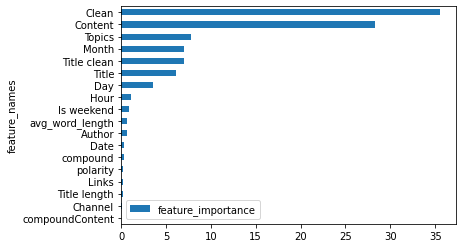

In [52]:
train_pool = Pool(X_final.values, y.values, cat_features=cat_features_idx, text_features=text_features_idx)
model.fit(train_pool)

data = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': X_final.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data.sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

## Make Prediction

In [47]:
X_test = pd.read_csv('./test_v2.csv')
print(X_test.head(5))

      Id                                              Title  Title length  \
0  27643  soccer star get twitter death threat tackling ...            10   
1  27644                   google glass get accessory store             5   
2  27645            ouya gaming console already sold amazon             6   
3  27646                        two fern mock oscar nominee             5   
4  27647  american sniper trailer look like eastwood may...             9   

                                         Title clean  Images  Links  \
0  Soccer Star Gets Twitter Death Threats After T...       1     30   
1               Google Glass Gets an Accessory Store       3     13   
2     OUYA Gaming Console Already Sold Out on Amazon       2     13   
3           'Between Two Ferns' Mocks Oscar Nominees       1     15   
4  'American Sniper' Trailer: Looks Like Eastwood...       1     10   

                                             Content  \
0  note humanity one direction fandom nothin mess...  

In [49]:
X_test.isnull().sum()

Id                      0
Title                   0
Title length            0
Title clean             0
Images                  0
Links                   0
Content                 1
Clean                   0
Word count              0
Day                     1
Month                   1
Hour                    1
Topics                 17
Topics length           0
Author                  0
Date                    1
neg                     0
neu                     0
pos                     0
compound                0
negContent              0
neuContent              0
posContent              0
compoundContent         0
Channel                 0
Is weekend              1
polarity                0
subjectivity            0
char_count              0
sentence_count          0
avg_word_length         1
avg_sentence_length     0
dtype: int64

## Make the column for testing set and training sets the same

In [48]:
lst = list(df.columns)
lst.remove('Popularity')
X_test = X_test[lst]
X_test.head()

KeyError: "['Page content'] not in index"

## Choose features and split to category and text features

In [55]:
X_test = X_test.iloc[:,1:]
# X_category_test = X_test.drop(['Topics','Title','Topics length', 'Images', 'Word count', 'Content', 'Clean','Author','Channel'], axis=1)
X_category_test = X_test[['polarity','Title length','Links','compound','compoundContent','avg_word_length','Hour','Day','Month','Date','Is weekend']]
X_text_test = X_test[['Topics','Title','Clean','Content','Channel','Title clean', 'Author']]
column = X_category_test.columns

## Impute missing text with space

In [56]:
X_text_test['Topics'].fillna(' ', inplace = True)
X_text_test['Content'].fillna(' ', inplace = True)
X_text_test['Clean'].fillna(' ', inplace = True)
X_text_test['Title'].fillna(' ', inplace = True)
X_text_test['Author'].fillna(' ', inplace = True)
X_text_test['Channel'].fillna(' ', inplace = True)

C:\Users\USER\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Impute category features

In [57]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imr = imr.fit(X_category_test.values)
imputed_data = imr.transform(X_category_test.values)

X_category_test = pd.DataFrame(imputed_data)
X_category_test.columns = column
X_category_test.head()

polarity Title length Links compound compoundContent avg_word_length  \
0   0.0581818           10    30  -0.8074       -0.273344         6.02535   
1    0.199184            5    13        0        0.188583          5.6506   
2   0.0189981            6    13   0.1779        0.128031         5.84685   
3   0.0174352            5    15  -0.4215        0.305886         5.95575   
4  0.00836354            9    10   0.3612        -0.14412         5.78417   

  Hour  Day Month Date Is weekend  
0   19  Mon     9    9          0  
1    9  Thu    10   31          0  
2   12  Tue     6   25          0  
3    3  Wed     2   13          0  
4    1  Fri    10    3          0

## Convert hour, month, date, is weekend back to integer

In [58]:
X_category_test["Hour"] = X_category_test["Hour"].apply(lambda x: int(x))
X_category_test["Month"] = X_category_test["Month"].apply(lambda x: int(x))
X_category_test["Date"] = X_category_test["Date"].apply(lambda x: int(x))
X_category_test["Is weekend"] = X_category_test["Is weekend"].apply(lambda x: int(x))

## Combine category and text back to 1 dataset
Ensures test features the same as training set column

In [59]:
X_final_test = pd.concat([X_category_test, X_text_test], axis=1)
X_final_test = X_final_test[X_final.columns]
X_final_test.head()

polarity Title length Links compound compoundContent avg_word_length  \
0   0.0581818           10    30  -0.8074       -0.273344         6.02535   
1    0.199184            5    13        0        0.188583          5.6506   
2   0.0189981            6    13   0.1779        0.128031         5.84685   
3   0.0174352            5    15  -0.4215        0.305886         5.95575   
4  0.00836354            9    10   0.3612        -0.14412         5.78417   

   Hour  Day  Month  Date          Author  Is weekend  \
0    19  Mon      9     9       Sam Laird           0   
1     9  Thu     10    31  Stan Schroeder           0   
2    12  Tue      6    25  Todd Wasserman           0   
3     3  Wed      2    13    Neha Prakash           0   
4     1  Fri     10     3     Josh Dickey           0   

                                              Topics  \
0     soccer entertainment one_direction music sport   
1              gadget glass google_glass tech google   
2               amazon_kindle business gaming amazon   
3  watercooler oscar_2013 video two_fern oscar movie   
4  award clint_eastwood entertainment bradley_coo...   

                                               Title  \
0  soccer star get twitter death threat tackling ...   
1                   google glass get accessory store   
2            ouya gaming console already sold amazon   
3                        two fern mock oscar nominee   
4  american sniper trailer look like eastwood may...   

                                               Clean  \
0       Note to humanity: One Direction fandom ai...   
1   Shortly after announcing a hardware upgrade f...   
2   Well, that was quick. Just hours after going ...   
3    Between Two Ferns: Oscar Buzz Edition Part 1...   
4       Ever since The Hurt Locker it seems like ...   

                                             Content        Channel  \
0  note humanity one direction fandom nothin mess...  entertainment   
1  shortly announcing hardware upgrade google gla...           tech   
2  well quick hounited statesafter going sale uni...       business   
3  two fern oscar buzz edition part 1 zach galifi...           film   
4  ever since hurt locker seems like military the...  entertainment   

                                         Title clean  
0  Soccer Star Gets Twitter Death Threats After T...  
1               Google Glass Gets an Accessory Store  
2     OUYA Gaming Console Already Sold Out on Amazon  
3           'Between Two Ferns' Mocks Oscar Nominees  
4  'American Sniper' Trailer: Looks Like Eastwood...

## Define category and text features

In [60]:
cat_features = ['Day', 'Month','Hour','Channel','Date','Author','Is weekend']
cat_features_idx = [X_final.columns.get_loc(c) for c in cat_features]
text_features = ['Title', 'Topics','Clean','Content','Title clean']
text_features_idx = [X_final.columns.get_loc(t) for t in text_features]


In [63]:
X_category.isnull().sum()

polarity           0
Title length       0
Links              0
compound           0
compoundContent    0
avg_word_length    0
Hour               0
Day                0
Month              0
Date               0
Author             0
Is weekend         0
dtype: int64

## Fit to model and predict the probability

In [61]:
model = CatBoostClassifier(task_type='GPU', cat_features=cat_features_idx, text_features=text_features_idx, verbose=500, learning_rate=0.01, n_estimators=500, l2_leaf_reg=10, max_depth=8)
model.fit(X_final, y)

y_pred = model.predict_proba(X_final_test)

0:	learn: 0.6928479	total: 391ms	remaining: 3m 15s
499:	learn: 0.6588252	total: 2m 33s	remaining: 0us


CatBoostError: Invalid type for text_feature[non-default value idx=11847,feature_idx=17]=nan : text_features must have string type

## Save to submission.csv

In [ ]:
df = pd.read_csv('./test.csv')
df2 = pd.DataFrame(y_pred, columns=['Popularity 0', 'Popularity'])
submission = pd.concat([df['Id'], df2], axis=1)
sub = submission.drop(['Popularity 0'], axis=1)
sub['Id'] = sub['Id'].apply(lambda x: int(x))
sub.to_csv('./submission.csv', index=False)
sub.head()